In [1]:
import os
import sys
import numpy                                  as np
import time
import shutil
import seaborn                                as sns
import pysftp                                 as sftp
import pandas                                 as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['legend.fontsize'] = 35

<ipython-input-1-ca62a2d6d684>:15: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


In [2]:
LocalFlg         = 'True'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
    
PathToOutputFldr =  WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/'
print(PathToOutputFldr)

## O2+O
# Molecules        = ['O2_UMN']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp']
# Molwe = []

### N2+N
Molecules        = ['N2_LeRoy']
PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']

# Molecules        = ['O2_UMN','N2_LeRoy','N2_UMN_ForN2O2']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp',
#                     WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
#                     WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp']

### N2+O
# Molecules        = ['NO_UMN', 'N2_UMN_ForN2O2']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp',
#                     WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp']

Molecules        = ['N2_LeRoy','O2_UMN']
PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp']

# ## CO+O
# Molecules        = ['CO_NASA', 'O2_NASA']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/CO/NASA/CO_levels_NASA.dat', 
#                     WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/NASA/O2_levels_venturi_new.dat']

# # ### CN+H
# Molecules     = ['CN_UIUC']
# PathToDiatPot = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/CN_fromPES/Modified_Morse/CN_Temp.inp']

UnitOfMeasure = 27.211396641308

/home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/


In [3]:
def compute_vibenergy(eint, vqn, jqn):
    NLevels = len(eint)
    EVib    = np.zeros((NLevels,1))
    ERot    = np.zeros((NLevels,1))
    ETemp   = np.zeros((np.amax(vqn)+1,1))
    for iLevel in range(NLevels):
        if (jqn[iLevel] == 0):
            EVib[iLevel]       = eint[iLevel]
            ETemp[vqn[iLevel]] = eint[iLevel]
        else:
            EVib[iLevel] = ETemp[vqn[iLevel]]
            ERot[iLevel] = eint[iLevel] - EVib[iLevel]
    return EVib, ERot


def compute_rotenergy(eint, vqn, jqn):
    NLevels = len(eint)
    EVib    = np.zeros((NLevels,1))
    ERot    = np.zeros((NLevels,1))
    ETemp   = np.zeros((np.amax(jqn)+1,1))
    for iLevel in range(NLevels):
        if (vqn[iLevel] == 0):
            ERot[iLevel]       = eint[iLevel]
            ETemp[jqn[iLevel]] = eint[iLevel]
        else:
            ERot[iLevel] = ETemp[jqn[iLevel]]
            EVib[iLevel] = eint[iLevel] - ERot[iLevel]
    return EVib, ERot

In [4]:
NMolecules = len(Molecules)
for iMol in range(NMolecules):
    
    
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
    
    ### Shifting Energies so that Zero is the Min of Diatomic Potential at J=0
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  #/ VDiss
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  #/ VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() #/ VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() #/ VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  #/ VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  #/ VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    print(rMin)
    LevelsDataNew['ri']   = LevelsData.ri.to_numpy()   #/ LevelsData.rMin.to_numpy()
    LevelsDataNew['ro']   = LevelsData.ro.to_numpy()   #/ LevelsData.rMin.to_numpy()
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() #/ rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) #/ rMin
    LevelsDataNew['rMaxro']   = LevelsData['rMax'].to_numpy() -  LevelsData['ro'].to_numpy()
    LevelsDataNew['rori']     = LevelsData['ri'].to_numpy()   -  LevelsData['ro'].to_numpy()
    LevelsDataNew['rMaxrMin'] = LevelsData['rMax'].to_numpy() -  LevelsData['rMin'].to_numpy()
    LevelsDataNew['DeltarTot']= LevelsDataNew['rMaxrMin'].to_numpy() -  LevelsDataNew['rori'].to_numpy()

    TauMin                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  #/ TauMin
    
    
    ### Taking Logarithms --> can not be done if we shift the energy reference to VMax at J = 0.
    LevelsDataNew['log_ro']    = np.log10(LevelsData.ro.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsData.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsData.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsData.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsData.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsData.EInt.to_numpy()  + 0.)
    LevelsDataNew['log_EVib']  = np.log10(LevelsData.EVib.to_numpy()  + 0.)
    LevelsDataNew['log_ERot']  = np.log10(LevelsData.ERot.to_numpy()  + 1.e-8)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsData.EVibR.to_numpy() + 1.e-8)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsData.ERotR.to_numpy() + 0.)
    LevelsDataNew['log_VMin']  = np.log10(LevelsData.VMin.to_numpy()  + 1.e-8)
    LevelsDataNew['log_VMax']  = np.log10(LevelsData.VMax.to_numpy()  + 0.)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)
    LevelsDataNew['log_rMaxro']   = np.log10(LevelsDataNew.rMaxro.to_numpy()  + 0.)
#     LevelsDataNew['log_rori']     = np.log10(LevelsDataNew.rori.to_numpy()  + 0.)
#     LevelsDataNew['log_rMaxrMin'] = np.log10(LevelsDataNew.rMaxrMin.to_numpy()  + 0.)
#     LevelsDataNew['log_DeltarTot']= np.log10(LevelsDataNew.DeltarTot.to_numpy()  + 0.)
# 
    mp.pyplot.plot(LevelsData.EInt, LevelsDataNew.log_ro, 'o', linewidth=2, markersize=12, label=Molecules[iMol])

    
    #pd.plotting.scatter_matrix(LevelsDataNew[['ERot','EVib','ERotR','EVibR','rMin','rMax','VMin','VMax','Tau','ri','ro']], figsize=(15,15))


2.0738111


<ipython-input-4-1dc78ac3db90>:66: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EInt']  = np.log10(LevelsData.EInt.to_numpy()  + 0.)
<ipython-input-4-1dc78ac3db90>:67: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EVib']  = np.log10(LevelsData.EVib.to_numpy()  + 0.)
<ipython-input-4-1dc78ac3db90>:70: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_ERotR'] = np.log10(LevelsData.ERotR.to_numpy() + 0.)
<ipython-input-4-1dc78ac3db90>:71: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_VMin']  = np.log10(LevelsData.VMin.to_numpy()  + 1.e-8)
<ipython-input-4-1dc78ac3db90>:72: RuntimeWarning: divide by zero encountered in log10
  LevelsDataNew['log_VMax']  = np.log10(LevelsData.VMax.to_numpy()  + 0.)


NameError: name 'mp' is not defined

2.0738111


<ipython-input-15-c1cb36385620>:69: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EInt']  = np.log10(LevelsData.EInt.to_numpy()  + 0.)
<ipython-input-15-c1cb36385620>:70: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EVib']  = np.log10(LevelsData.EVib.to_numpy()  + 0.)
<ipython-input-15-c1cb36385620>:73: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_ERotR'] = np.log10(LevelsData.ERotR.to_numpy() + 0.)
<ipython-input-15-c1cb36385620>:74: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_VMin']  = np.log10(LevelsData.VMin.to_numpy()  + 1.e-8)
<ipython-input-15-c1cb36385620>:75: RuntimeWarning: divide by zero encountered in log10
  LevelsDataNew['log_VMax']  = np.log10(LevelsData.VMax.to_numpy()  + 0.)


2.282049


<ipython-input-15-c1cb36385620>:69: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EInt']  = np.log10(LevelsData.EInt.to_numpy()  + 0.)
<ipython-input-15-c1cb36385620>:70: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EVib']  = np.log10(LevelsData.EVib.to_numpy()  + 0.)
<ipython-input-15-c1cb36385620>:73: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_ERotR'] = np.log10(LevelsData.ERotR.to_numpy() + 0.)
<ipython-input-15-c1cb36385620>:74: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_VMin']  = np.log10(LevelsData.VMin.to_numpy()  + 1.e-8)
<ipython-input-15-c1cb36385620>:75: RuntimeWarning: divide by zero encountered in log10
  LevelsDataNew['log_VMax']  = np.log10(LevelsData.VMax.to_numpy()  + 0.)


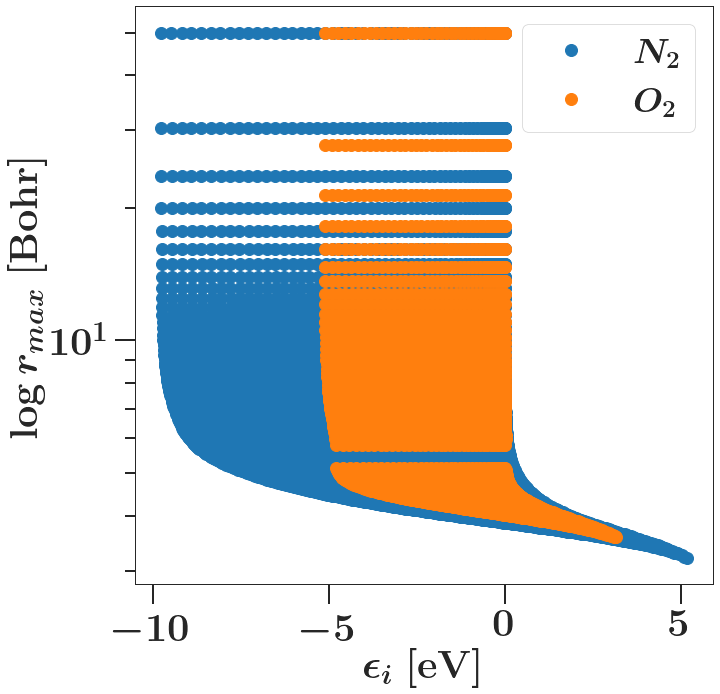

In [15]:
NMolecules = len(Molecules)
Molec=['$N_2$','$O_2$']
fig,ax = plt.subplots(1,1,figsize=(10,10)) 

for iMol in range(NMolecules):
    
    
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
    
    ### Shifting Energies so that Zero is the Min of Diatomic Potential at J=0
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy()) ) * UnitOfMeasure
    
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  #/ VDiss
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  #/ VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() #/ VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() #/ VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  #/ VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  #/ VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    print(rMin)
    LevelsDataNew['ri']   = LevelsData.ri.to_numpy()   #/ LevelsData.rMin.to_numpy()
    LevelsDataNew['ro']   = LevelsData.ro.to_numpy()   #/ LevelsData.rMin.to_numpy()
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() #/ rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) #/ rMin
    LevelsDataNew['rMaxro']   = LevelsData['rMax'].to_numpy() -  LevelsData['ro'].to_numpy()
    LevelsDataNew['rori']     = LevelsData['ri'].to_numpy()   -  LevelsData['ro'].to_numpy()
    LevelsDataNew['rMaxrMin'] = LevelsData['rMax'].to_numpy() -  LevelsData['rMin'].to_numpy()
    LevelsDataNew['DeltarTot']= LevelsDataNew['rMaxrMin'].to_numpy() -  LevelsDataNew['rori'].to_numpy()

    TauMin                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  #/ TauMin
    
    
    ### Taking Logarithms --> can not be done if we shift the energy reference to VMax at J = 0.
    LevelsDataNew['log_ro']    = np.log10(LevelsData.ro.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsData.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsData.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsData.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsData.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsData.EInt.to_numpy()  + 0.)
    LevelsDataNew['log_EVib']  = np.log10(LevelsData.EVib.to_numpy()  + 0.)
    LevelsDataNew['log_ERot']  = np.log10(LevelsData.ERot.to_numpy()  + 1.e-8)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsData.EVibR.to_numpy() + 1.e-8)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsData.ERotR.to_numpy() + 0.)
    LevelsDataNew['log_VMin']  = np.log10(LevelsData.VMin.to_numpy()  + 1.e-8)
    LevelsDataNew['log_VMax']  = np.log10(LevelsData.VMax.to_numpy()  + 0.)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)
    LevelsDataNew['log_rMaxro']   = np.log10(LevelsDataNew.rMaxro.to_numpy()  + 0.)
#     LevelsDataNew['log_rori']     = np.log10(LevelsDataNew.rori.to_numpy()  + 0.)
#     LevelsDataNew['log_rMaxrMin'] = np.log10(LevelsDataNew.rMaxrMin.to_numpy()  + 0.)
#     LevelsDataNew['log_DeltarTot']= np.log10(LevelsDataNew.DeltarTot.to_numpy()  + 0.)
# 

    mpl.pyplot.plot(LevelsData.EInt, LevelsDataNew.rMax, 'o', linewidth=2, markersize=12, label=Molec[iMol])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('$\epsilon_i$ \\textbf{[eV]}')
    plt.ylabel('$\log{r_{max}}$ \\textbf{[Bohr]}')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box') 
    fig.tight_layout(pad=0.75)                                                                                                             
    plt.savefig((PathToOutputFldr+'/rmax.pdf'), format='pdf', dpi=300) 
    
    #pd.plotting.scatter_matrix(LevelsDataNew[['ERot','EVib','ERotR','EVibR','rMin','rMax','VMin','VMax','Tau','ri','ro']], figsize=(15,15))


array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

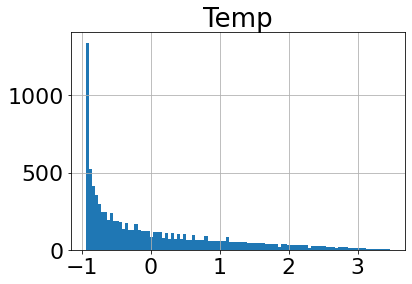

In [17]:
### ERot
Var  = 'VMin'

Mean = LevelsDataNew[Var].mean()
Std  = LevelsDataNew[Var].std()

LevelsDataNew['Temp']  = LevelsDataNew[Var].to_numpy()
LevelsDataNew['Temp']  = (LevelsDataNew[Var].to_numpy() - Mean)/Std
LevelsDataNew.hist(bins=100, column=['Temp'])

# E Reference to Bottom of the Well

In [6]:
NMolecules = len(Molecules)
# [O2, N2, NO, CO]
#we = np.array([0.1959, 0.2924, 0.23609082, 0.26902272523])
we = np.array([0.26902272523, 0.1959])

mp.pyplot.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')
fig = mp.pyplot.figure(figsize=(12,8))

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
#    LevelsData2        = pd.read_csv(PathToDiatPot[1], delim_whitespace=True, skiprows=15, header=None)  
#    LevelsData2.columns   = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']   
    
    ### Energy reference is at the bottom of the well. 
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / VDiss
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / VDiss
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri'] = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)
#     LevelsDataNew['delta_EVib'] = ((LevelsDataNew.log_EVib.to_numpy() - LevelsDataNew.log_EVib.to_numpy()[0]))
    
#     mp.pyplot.plot(LevelsDataNew.EInt, LevelsDataNew.delta_EVib, 'o', linewidth=2, markersize=2, label=Molecules[iMol])
#     plt.xlabel('Ei/VDiss')
#     plt.ylabel('Delta EVib')
#     #plt.ylim([1.25,2])

# mp.pyplot.legend(['O2','N2'])    

    # Writing datafile
#     LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_log_nd.csv', index=False)

<Figure size 864x576 with 0 Axes>

# Normalize EVib with we values with ERef at Bottom of well

In [4]:
NMolecules = len(Molecules)
# [O2, N2, NO, CO, CN]
#we = np.array([0.1959, 0.2924, 0.23609082, 0.26902272523, 0.25647259])
we = np.array([0.25647259])

mp.pyplot.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')
fig = mp.pyplot.figure(figsize=(12,8))

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
#    LevelsData2        = pd.read_csv(PathToDiatPot[1], delim_whitespace=True, skiprows=15, header=None)  
#    LevelsData2.columns   = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']   
    
    ### Energy reference is at the bottom of the well. 
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / VDiss
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / we[iMol]
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri']   = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)
  

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_Bottom_Vib_we_nd.csv', index=False)

<Figure size 864x576 with 0 Axes>

# E Referenced to Ground State

In [5]:
NMolecules = len(Molecules)

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
#    LevelsData2        = pd.read_csv(PathToDiatPot[1], delim_whitespace=True, skiprows=15, header=None)  
#    LevelsData2.columns   = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']   
    
    ### Energy reference is at the bottom of the well. 
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['EInt'].to_numpy())) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['EInt'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['EInt'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / VDiss
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / VDiss
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri'] = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)   

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_GroundState_log_nd.csv', index=False)

# Referenced to Dissociation Limit

In [6]:
NMolecules = len(Molecules)

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
    ### Energy reference is at the bottom of the well. 
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                  = -LevelsData['VMin'].to_numpy()[0]
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / VDiss
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / VDiss
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / VDiss
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / VDiss
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / VDiss
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / VDiss
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri'] = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)   

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_Diss_log_nd.csv', index=False)

<ipython-input-6-82cb82038055>:62: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
<ipython-input-6-82cb82038055>:63: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
<ipython-input-6-82cb82038055>:66: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)


# File for Heterogenous Exchange. E Referenced to Diss and Normalized by larger molecule depth

In [8]:
NMolecules = len(Molecules)

RefData        = pd.read_csv(PathToDiatPot[0], delim_whitespace=True, skiprows=15, header=None)  
RefData.columns   = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']
VRefVec = ( RefData['VMin'].to_numpy() -  np.amin(RefData['VMax'].to_numpy())) * UnitOfMeasure
VRef = -VRefVec[0];

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    

    ### Energy reference is at the bottom of the well. 
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMax'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()
    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / VRef
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / VRef
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / VRef
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / VRef
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / VRef
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / VRef
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / VRef
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri'] = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)   

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_Diss_log_nd_NORefForHeteroExch.csv', index=False)

<ipython-input-8-ac9b32fae4ac>:65: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
<ipython-input-8-ac9b32fae4ac>:66: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
<ipython-input-8-ac9b32fae4ac>:69: RuntimeWarning: invalid value encountered in log10
  LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)


# File for Heterogenous Exchange. E Referenced to Bottom of larger molecule and Normalized by larger molecule depth

In [4]:
NMolecules = len(Molecules)

RefData        = pd.read_csv(PathToDiatPot[0], delim_whitespace=True, skiprows=15, header=None)  
RefData.columns   = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']
VRefVec = ( RefData['VMax'].to_numpy() -  np.amin(RefData['VMin'].to_numpy())) * UnitOfMeasure
VRef = np.amin(RefData['VMin'].to_numpy())
Vnormalize = VRefVec[0];

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    

    ### Energy reference is at the bottom of the well. 
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  VRef) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  VRef) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  VRef) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()
    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    LevelsDataNew['EInt']  = LevelsData.EInt.to_numpy()  / Vnormalize
    LevelsDataNew['EVib']  = LevelsData.EVib.to_numpy()  / Vnormalize
    LevelsDataNew['ERot']  = LevelsData.ERot.to_numpy()  / Vnormalize
    LevelsDataNew['EVibR'] = LevelsData.EVibR.to_numpy() / Vnormalize
    LevelsDataNew['ERotR'] = LevelsData.ERotR.to_numpy() / Vnormalize
    LevelsDataNew['VMax']  = LevelsData.VMax.to_numpy()  / Vnormalize
    LevelsDataNew['VMin']  = LevelsData.VMin.to_numpy()  / Vnormalize
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    rMax                  = np.amax(LevelsData['rMax'].to_numpy())
    LevelsDataNew['ri'] = LevelsData.ri.to_numpy()   / rMin
    LevelsDataNew['rorMin'] = LevelsData.ro.to_numpy()   / rMin 
    LevelsDataNew['rorMax']  = LevelsData.ro.to_numpy()   / rMax  
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = np.minimum(LevelsData.rMax.to_numpy(), 50.) / rMax

    TauMax                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMax
    
    # Taking Log    
    LevelsDataNew['log_rorMin']    = np.log10(LevelsDataNew.rorMin.to_numpy())
    LevelsDataNew['log_rorMax']    = np.log10(LevelsDataNew.rorMax.to_numpy())
    LevelsDataNew['log_rMax']  = np.log10(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['log_ri']    = np.log10(LevelsDataNew.ri.to_numpy())
    LevelsDataNew['log_rMin']  = np.log10(LevelsDataNew.rMin.to_numpy())
    LevelsDataNew['log_Tau']   = np.log10(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['log_EInt']  = np.log10(LevelsDataNew.EInt.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVib']  = np.log10(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['log_ERot']  = np.log10(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
    LevelsDataNew['log_EVibR'] = np.log10(LevelsDataNew.EVibR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ERotR'] = np.log10(LevelsDataNew.ERotR.to_numpy() + 1.e-10)
    LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)   

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_log_nd_CORefForHeteroExch.csv', index=False)

<ipython-input-4-823370d1fd52>:71: RuntimeWarning: divide by zero encountered in log10
  LevelsDataNew['log_ECB']   = np.log10(LevelsData.ECB.to_numpy()   + 0.)


11.228284588250403

In [17]:
NMolecules = len(Molecules)
# [O2, N2, NO, CO]
#we = np.array([0.1959, 0.2924, 0.23609082, 0.26902272523])
we = np.array([0.26902272523, 0.1959])

mp.pyplot.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')
fig = mp.pyplot.figure(figsize=(12,8))

for iMol in range(NMolecules):
        
    ### Reading Levels Data
    if (LocalFlg):
        LevelsData        = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    else: 
        with sftp.Connection(host=IP, username=User) as conn:
            with conn.open(PathToDiatPot[iMol], "r") as f:
                LevelsData = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
    ### Energy reference is at the bottom of the well. 
    LevelsData['VMax']    = ( LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['EInt']    = ( LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['VMin']    = ( LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())) * UnitOfMeasure
    LevelsData['ECB']     =   LevelsData['VMax'].to_numpy() -  LevelsData['EInt'].to_numpy()

    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    EVibR, ERotR          = compute_rotenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVibR']   = EVibR
    LevelsData['ERotR']   = ERotR

    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    # Taking Log    
    LevelsDataNew['ro']    = np.log(LevelsDataNew.ro.to_numpy())
    LevelsDataNew['rMax']  = np.log(LevelsDataNew.rMax.to_numpy())
    LevelsDataNew['Tau']   = np.log(LevelsDataNew.Tau.to_numpy())    
    LevelsDataNew['EVib']  = np.log(LevelsDataNew.EVib.to_numpy()  + 1.e-10)
    LevelsDataNew['ERot']  = np.log(LevelsDataNew.ERot.to_numpy()  + 1.e-10)
#     LevelsDataNew['delta_EVib'] = ((LevelsDataNew.log_EVib.to_numpy() - LevelsDataNew.log_EVib.to_numpy()[0]))
    
#     mp.pyplot.plot(LevelsDataNew.EInt, LevelsDataNew.delta_EVib, 'o', linewidth=2, markersize=2, label=Molecules[iMol])
#     plt.xlabel('Ei/VDiss')
#     plt.ylabel('Delta EVib')
#     #plt.ylim([1.25,2])

# mp.pyplot.legend(['O2','N2'])    

    # Writing datafile
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_LogER_ro_tau_rMax.csv', index=False)

<Figure size 864x576 with 0 Axes>

In [10]:
LevelsDataNew['log_ro']

0       0.876509
1       0.876516
2       0.876530
3       0.876551
4       0.876579
          ...   
6073    1.176449
6074    1.182460
6075    1.189144
6076    1.197008
6077    1.207789
Name: log_ro, Length: 6078, dtype: float64

In [11]:
LevelsDataNew['log_rMax']

0       3.912023
1       3.786461
2       3.531048
3       3.362812
4       3.237155
          ...   
6073    1.254700
6074    1.250868
6075    1.246785
6076    1.242394
6077    1.237614
Name: log_rMax, Length: 6078, dtype: float64

In [5]:
2.282049/2.0738111

1.1004131475619936